# Exploring Seattle Pet Licenses

In [6]:
# Load Packages
from pprint import pprint
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

# Assess Directories
# Path.home() # Profile root directory
Path.cwd() # https://realpython.com/python-pathlib/
# Path('c:/Users/tbonn/Code/Python/Local/Data_Nash/Excel_File').parent # Parent directory of the string

# Create Data Filepath
# data_filepath = Path.cwd() / 'Data' / 'Seattle_Pet_Licenses.xlsx' # / pastes filepaths together
data_filepath = Path(r'C:\Users\tbonn\Code\Python\Local\Data_Nash\Excel_File\Data\Seattle_Pet_Licenses.xlsx')
pprint(data_filepath)


WindowsPath('C:/Users/tbonn/Code/Python/Local/Data_Nash/Excel_File/Data/Seattle_Pet_Licenses.xlsx')


## Read in the Data
Source: [Seattle Open Data Portal](https://data.seattle.gov/Community/Seattle-Pet-Licenses/jguv-t9rb/about_data)

In [7]:
# Read In Data
dat = pd.read_excel(data_filepath)

## Explore the Data

In [8]:
# Summary Peak of the Data
dat.head(10)

# Column Names & Nrows/Ncols
dat.columns
dat.shape

# Descriptions of Variable Types
dat.info() # Python Data Types: https://pbpython.com/pandas_dtypes.html

# Brief Summary Statistics of Variables
dat.describe()
print(dat.isnull().sum()) # Number of null values in each column.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42526 entries, 0 to 42525
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   License Issue Date  42526 non-null  object
 1   License Number      42526 non-null  object
 2   Animal's Name       42485 non-null  object
 3   Species             42526 non-null  object
 4   Primary Breed       42526 non-null  object
 5   Secondary Breed     28056 non-null  object
 6   ZIP Code            42409 non-null  object
dtypes: object(7)
memory usage: 2.3+ MB
License Issue Date        0
License Number            0
Animal's Name            41
Species                   0
Primary Breed             0
Secondary Breed       14470
ZIP Code                117
dtype: int64


## Clean Data Frame

In [9]:
## Convert Date Strings to Date Variables
dat['Date'] = pd.to_datetime(dat['License Issue Date'], format="%B %d %Y"); pprint(dat['Date'].head())

## Order Rows by Date (Asc; Earliest to Most Recent)
dat.sort_values('Date', ascending=True)

## Rename and Drop Variables
dat = dat.rename(columns= {
   'License Number': 'License_Number',
   'Animal\'s Name': "Animal_Name",
   'Primary Breed': 'Primary_Breed',
   'Secondary Breed': 'Secondary_Breed',
   'ZIP Code': 'Zip'}).drop(columns = ['License Issue Date'])

col_order = ['Date', 'Zip', 'License_Number', 'Species', 'Primary_Breed', 'Secondary_Breed', 'Animal_Name']
dat_clean = dat[col_order]

del col_order

## Extract Year and Month Variables from Date
dat_clean['Year'] = dat_clean['Date'].dt.year
dat_clean['Month'] = dat_clean['Date'].dt.month
dat_clean['Day'] = dat_clean['Date'].dt.day

0   2015-12-18
1   2016-06-14
2   2016-08-04
3   2019-02-13
4   2019-08-10
Name: Date, dtype: datetime64[ns]


C:\Users\tbonn\AppData\Local\Temp\ipykernel_25220\428577855.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dat_clean['Year'] = dat_clean['Date'].dt.year
C:\Users\tbonn\AppData\Local\Temp\ipykernel_25220\428577855.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dat_clean['Month'] = dat_clean['Date'].dt.month
C:\Users\tbonn\AppData\Local\Temp\ipykernel_25220\428577855.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_in

## Pet License Analysis

<u>This analysis will seek to answer **5** key questions related to the City of Seattle Pet License Data:</u>

1) What is the number of pet licenses granted by month-year? Has the number of pet licenses granted increased over the past few years?
2) What day of the year (for each year and across all years) has the highest number of pet licenses filed? 
3) What is the most popular breed (primary breed) of cats, dogs, goats, and pigs?
4) What is the most popular name for cats, dogs, goats, and pigs?
5) What Seattle zipcode(s) had the highest and lowest number of pet licenses over the past few years? Are there are notable qualities about these zipcodes that may influence this metric?


In [26]:
sns.set_style("whitegrid")

### Question 1
What is the number of pet licenses granted by month-year? Has the number of pet licenses granted increased over the past few years?

C:\Users\tbonn\AppData\Local\Temp\ipykernel_25220\2481284696.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_q1['MonthYear'] = df_q1['Date'].dt.to_period('M')
C:\Users\tbonn\AppData\Local\Temp\ipykernel_25220\2481284696.py:13: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', True)` for the same effect.

  sns.barplot(data=df_q1, x='MonthYear', y='Count', ci=True)


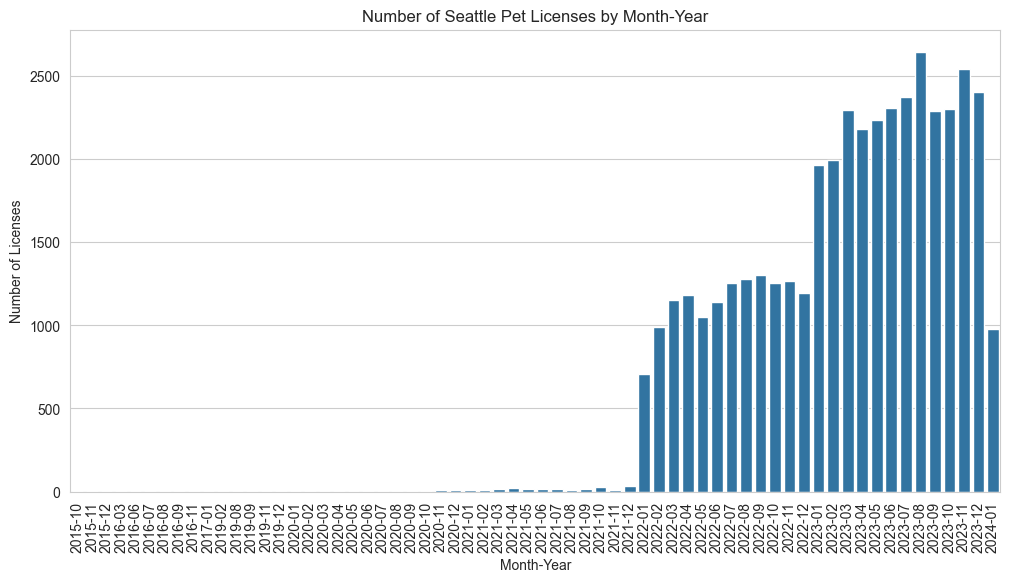

In [27]:
df_q1 = dat_clean

# Create Date-Month Variable
df_q1['MonthYear'] = df_q1['Date'].dt.to_period('M')


# Count Pet License by DateMonth
df_q1 = df_q1.groupby('MonthYear').size().reset_index(name='Count')

# Create Seaborn Bar Plot
plt.figure(figsize=(12, 6)) # Set figure size

sns.barplot(data=df_q1, x='MonthYear', y='Count', ci=True)

## Configure Titles & Axes
plt.title('Number of Seattle Pet Licenses by Month-Year')
plt.xlabel('Month-Year')
plt.ylabel('Number of Licenses')
plt.xticks(rotation=90)

plt.show()

### Question 2
What day of the year (for each year and across all years) has the highest number of pet licenses filed?

In [151]:
# Define Custom Functions

## 1) Find Top Breeds by Species
def find_top_breed(df, species, breed_type = 'Primary_Breed'):
    """Extract the top breed for a designated species"""

    # 1) Generate Summary DF (Counts of Primary/Seconday Breeds Grouped by Species)
    top_breeds = (
        df[['Species', breed_type]]
        .groupby('Species')
        .value_counts()
        .reset_index()
    )

    # 2) Extract Top Breed by Species
    breed = (
        top_breeds
        .query('Species == @species')
        .iloc[0]
        .reset_index()
    )

    # 3) Return breed
    return breed 

### Q1: What is the Number of Seattle Pet Licenses (by Species)?

C:\Users\tbonn\AppData\Local\Temp\ipykernel_21512\608219963.py:5: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=species_counts, x='Species', y='count', ci=None)


<Axes: xlabel='Species', ylabel='count'>

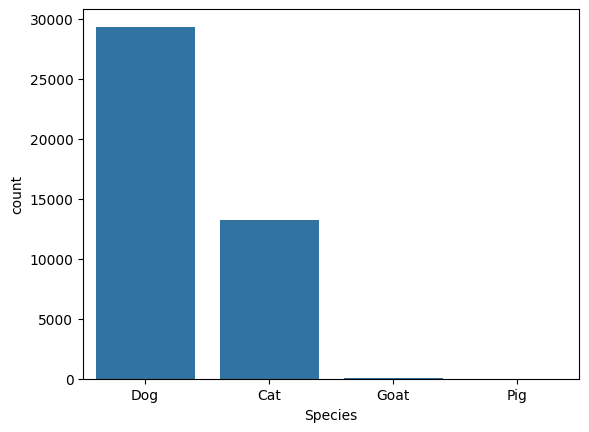

In [152]:
## Q1: Number of Licenses by Species
species_counts = dat_clean['Species'].value_counts() # There were 21 and 2 pet licenses submitted for Goats and Pigs respectively!
species_counts = pd.DataFrame(species_counts)

sns.barplot(data=species_counts, x='Species', y='count', ci=None)

### Q2: What Seattle Zipcode has the greatest number of pet licenses?

C:\Users\tbonn\AppData\Local\Temp\ipykernel_21512\771592904.py:4: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=zip_counts, x='Zip', y='count', ci=None)


<Axes: xlabel='Zip', ylabel='count'>

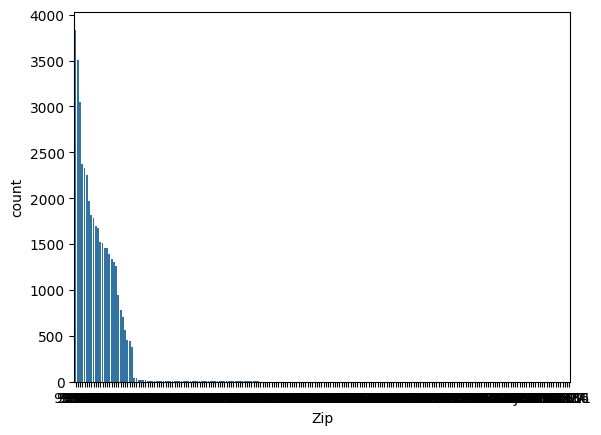

In [153]:
## Q2: Pet Licenses by Zip Code
zip_counts = dat_clean['Zip'].value_counts().reset_index()

sns.barplot(data=zip_counts, x='Zip', y='count', ci=None)

### Q3: How does the number of pet licenses change (year over year)?

C:\Users\tbonn\AppData\Local\Temp\ipykernel_21512\1475785609.py:4: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=yearly_counts, x='Year', y='count', ci=None)


<Axes: xlabel='Year', ylabel='count'>

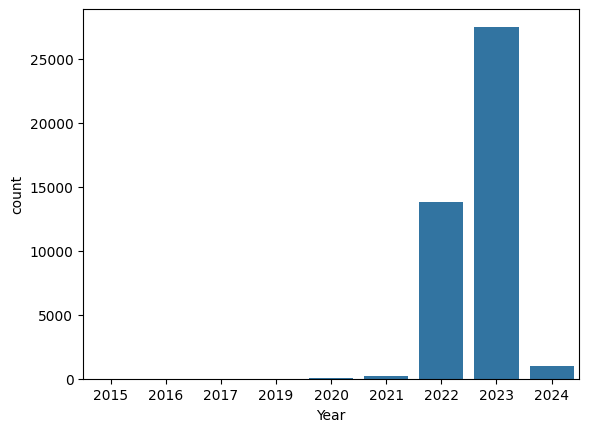

In [155]:
## Q3: Pet Licenses by Year
yearly_counts = dat_clean['Year'].value_counts().reset_index()

sns.barplot(data=yearly_counts, x='Year', y='count', ci=None)

### Q4: What are the most popular primary breeds for each species? 

In [145]:
## Q4: Most Popular Breeds by Species
top_breeds_cat = find_top_breed(df=dat_clean, species='Cat', breed_type='Primary_Breed')
top_breeds_dog = find_top_breed(df=dat_clean, species='Dog', breed_type='Primary_Breed')
top_breeds_goat = find_top_breed(df=dat_clean, species='Goat', breed_type='Primary_Breed')
top_breeds_pig = find_top_breed(df=dat_clean, species='Pig', breed_type='Primary_Breed')